We first identify temporal states according to Laplacian and activity distances, following the idea of N. Masuda, P. Holme "Detecting sequences of system states in temporal networks", $\textit{Sci. Rep.}$ (2018).
We then identify communities in the aggregated Laplacian states.
States and communities are saved to be used by the generation notebook.

In [1]:
import numpy as np
import networkx as nx
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import AgglomerativeClustering
import glob
import os
from ETN import count_ETN, get_dict, obtain_ETN_subgraph, get_ETNS
import community as community_louvain
from utils import *
from topological_metrics import get_weighted_graph, find_communities_Louvain
import random

### Load original graph

In [2]:
#dataset = "pr_school"; orig_gap = 300; state_gap = 1200
#dataset = "h_school11"; orig_gap = 1200; state_gap = 1200
#dataset = "h_school13"; orig_gap = 1200; state_gap = 1200
#dataset = "InVS15"; orig_gap = 3600; state_gap = 3600
dataset = "hypertext"; orig_gap = 1200; state_gap = 1200

Load original graph with resolution state_gap

In [3]:
data_in = load_data("Datasets/"+dataset+".dat")
orig_graph = build_graphs(data_in,gap=state_gap)

In [4]:
T = len(orig_graph)

### Functions

In [5]:
def find_eigenvalues_norm_Lapl(G):
    Ln = nx.normalized_laplacian_matrix(G)
    
    eigenvalues, _ = LA.eig(Ln.toarray())
    return np.sort(np.round(eigenvalues.real,5))

In [6]:
def normalized_spectrum_distance(eig1,eig2):
    # numerator
    Num = 0
    for n in range(len(orig_graph[0].nodes())):
        Num += (eig1[n] - eig2[n])**2
    # denominator
    S1 = 0
    S2 = 0
    for n in range(len(orig_graph[0].nodes())):
        S1 += (eig1[n])**2
        S2 += (eig2[n])**2
    Den = max(S1,S2)
    if Den == 0:
        Res = 0
    else: 
        Res = np.sqrt(Num/Den)
    return Res

In [7]:
def etn_length_dist(E0,E1):
    L0 = []
    for key in list(E0.keys()):
        L0.append(len(key))
    L1 = []
    for key in list(E1.keys()):
        L1.append(len(key))
    
    if (np.mean(L0) + np.mean(L1)) == 0:
        return 0
    else:
        return np.abs(np.mean(L0) - np.mean(L1))/(np.mean(L0) + np.mean(L1))

In [8]:
def max_Dunn_states(Cmin,Cmax,dist_matrix):
    Dunn = {}
    for C in range(Cmin,Cmax):
        max_in_dist = -10
        min_ex_dist = 1000
        clustering = AgglomerativeClustering(n_clusters=C, affinity='precomputed', linkage='average')
        cluster_labels = clustering.fit_predict(dist_matrix)
        sizes = [] # clusters sizes
        for ll in np.unique(cluster_labels):
            sizes.append(list(cluster_labels).count(ll))
        if np.min(sizes) > 1:
            for ti in range(len(cluster_labels)-1):
                for tj in range(ti+1,len(cluster_labels)):
                    dist = dist_matrix[ti][tj]
                    if cluster_labels[ti] == cluster_labels[tj]:
                        if dist > max_in_dist:
                            max_in_dist = dist
                    elif cluster_labels[ti] != cluster_labels[tj]:
                        if dist < min_ex_dist:
                            min_ex_dist = dist
            if max_in_dist == -10:
                print('-10',max_in_dist,min_ex_dist)
                Dunn[C] = 0
            if max_in_dist == 0:
                print('0',max_in_dist,min_ex_dist)
                Dunn[C] = 0
            else:
                Dunn[C] = min_ex_dist/max_in_dist

    plt.plot(Dunn.keys(),Dunn.values(),'o-')
    plt.grid()
    
    # I choose the nb of clusters with the maximum Dunn's index (if it corresponds to multiple values of C I choose the largest)
    num_clusters = max([key for key in Dunn if Dunn[key] == max(Dunn.values())]) 

    clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', linkage='average')
    states = clustering.fit_predict(dist_matrix)
    
    return states

In [9]:
def find_l_intra_l_inter(G,communities):
    l_intra = 0
    l_inter = 0
    for edge in G.edges():
        #print(edge,metadata[edge[0]],metadata[edge[1]])
        if communities[edge[0]] == communities[edge[1]]:
            l_intra += 1
        else:
            l_inter += 1
    return l_intra, l_inter

In [10]:
def obtain_p_intra(classes,cluster_sizes,l_intra):
    S = 0
    for class_ in classes:
        S += cluster_sizes[class_]*(cluster_sizes[class_] - 1)
    p_intra = 2*l_intra/S
    return p_intra

In [11]:
def obtain_p_inter(classes,cluster_sizes,N,l_inter):
    S = 0
    for class_ in classes:
        S += cluster_sizes[class_]*(N - cluster_sizes[class_])
    if l_inter == 0:
        p_inter = 0
    else:
        p_inter = 2*l_inter/S
    return p_inter

In [12]:
def find_cluster_sizes(classes,communities):
    cluster_sizes = {}
    for label in classes:
        cluster_sizes[label] = 0
    for node in communities:
        for class_ in classes:
            if communities[node] == class_:
                cluster_sizes[class_] += 1   
    return cluster_sizes

# Laplacian states $s_{\mathcal{L}}$

### Distance between all times

Eigenvalues

In [13]:
Eig_all = {}
for t in range(T):
    Eig_all[t] = find_eigenvalues_norm_Lapl(orig_graph[t])

Distance

In [14]:
dist_L = [[0] * T for row in range(T)]
for t1 in range(T-1):
    #print(t1)
    for t2 in range(t1+1,T):
        dist_L[t1][t2] = normalized_spectrum_distance(Eig_all[t1],Eig_all[t2])
        dist_L[t2][t1] = dist_L[t1][t2]

### Cluster temporal layers into states

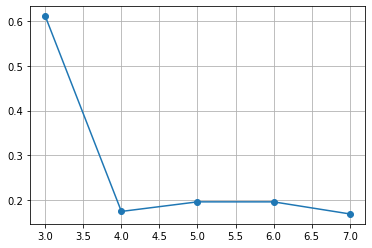

In [15]:
states_L = max_Dunn_states(3,60,dist_L)

In [16]:
num_clusters = len(np.unique(states_L))

### Save states

In [17]:
directory = 'Datasets/Lapl_states_%s_gap_%d_%dstates/'%(dataset,state_gap,num_clusters)
print(directory)
if not os.path.exists(directory):
    os.makedirs(directory)
np.save(directory+'states.npy',states_L)

Datasets/Lapl_states_hypertext_gap_1200_3states/


### Plot

In [18]:
plt.rcParams.update({'font.size': 16}) # for article

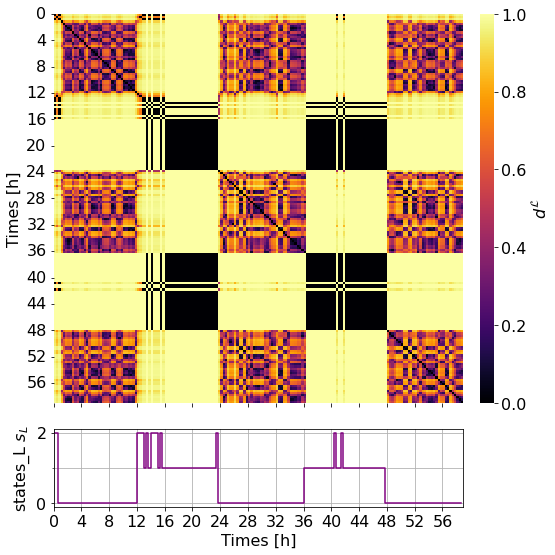

In [19]:
fig, ax  = plt.subplots(2,2,sharex='col',gridspec_kw={'width_ratios':[90,3],'height_ratios':[5,1]},figsize=(8,8))



maxValue = max([max(dist_L[n]) for n in range(len(dist_L))])
minValue = min([min(dist_L[n]) for n in range(len(dist_L))])
sns.heatmap(dist_L,
            annot=False, 
            vmin=minValue, 
            vmax=maxValue,
            cmap="inferno",
            linewidths=-0,
            cbar_kws={'label': '$d^{\mathcal{L}}$'},
            ax=ax[0,0], 
            cbar_ax=ax[0,1])
ax[0,0].set_ylabel('Times [h]')
ax[0,0].set_yticks(np.arange(len(states_L))[0::12],[int(x) for x in np.arange(len(states_L))[0::12]*state_gap/3600])


ax[1,0].step(np.arange(len(states_L)),states_L,c='purple')
ax[1,0].set_ylabel('states_L $s_L$')
ax[1,0].set_xlabel('Times [h]')
ax[1,0].set_xticks(np.arange(len(states_L))[0::12],[int(x) for x in np.arange(len(states_L))[0::12]*state_gap/3600])
minor_ticks = np.arange(0, 3, 1)
ax[1,0].set_yticks(minor_ticks, minor=True)
ax[1,0].grid(axis='both',which='both')

ax[1,1].remove()  # remove unused upper right axes

plt.tight_layout()


if not os.path.exists('figs/'):
    os.makedirs('figs/')
plt.savefig('figs/temporal_distance_%s_%dstates_L_Lapl_orig_gap_%d.png'%(dataset,num_clusters,state_gap))
plt.show()

# Activity states $s_e$

 Set the depth of Egocentric Temporal neighborhood, to compute $k_d$ for every node at every time

In [20]:
d = 2

### Distance between all times

In [21]:
ETNS_dict_list = []
for t in range(T-d):
    ETNS_dict = dict()
    graphs = orig_graph[t:t+d+1] # prendo il tempo t e i d successivi
    for v in graphs[0].nodes():
        etn = obtain_ETN_subgraph(graphs,v)
        if not etn == None:
            etns,_ = get_ETNS(etn)
            if etns in ETNS_dict.keys():
                ETNS_dict[etns] = ETNS_dict[etns] + 1
            else:
                ETNS_dict[etns] = 1
    ETNS_dict_list.append(ETNS_dict)


In [22]:
dist_e = [[0] * (T-d) for row in range(T-d)]
for t1 in range(T-d-1):
    #print(t1)
    for t2 in range(t1+1,T-d):
        dist_e[t1][t2] = etn_length_dist(ETNS_dict_list[t1],ETNS_dict_list[t2])
        dist_e[t2][t1] = dist_e[t1][t2]

### Cluster temporal layers

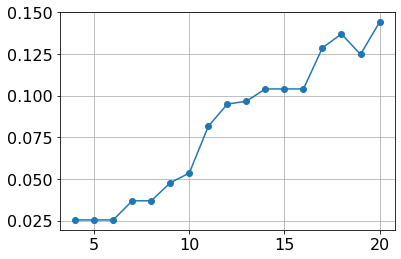

In [23]:
states_e = max_Dunn_states(4,60,dist_e)

### Save states

In [24]:
num_clusters = len(np.unique(states_e))

In [25]:
directory = 'Datasets/etn_states_%s_gap_%d_%dstates/'%(dataset,state_gap,num_clusters)
print(directory)
if not os.path.exists(directory):
    os.makedirs(directory)
np.save(directory+'states.npy',states_e)

Datasets/etn_states_hypertext_gap_1200_20states/


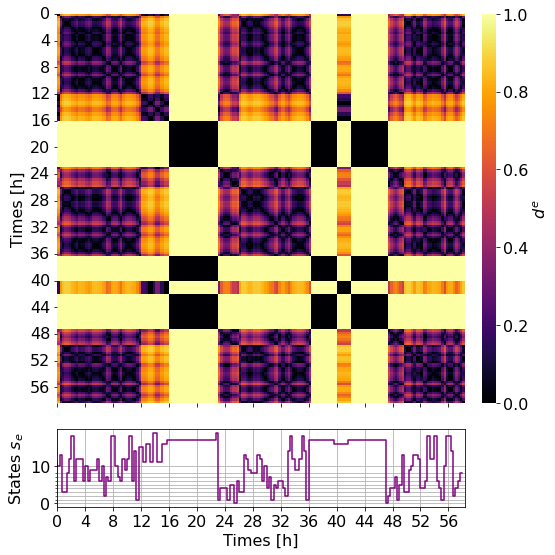

In [26]:
fig, ax  = plt.subplots(2,2,sharex='col',gridspec_kw={'width_ratios':[90,3],'height_ratios':[5,1]},figsize=(8,8))



maxValue = max([max(dist_e[n]) for n in range(len(dist_e))])
minValue = min([min(dist_e[n]) for n in range(len(dist_e))])
sns.heatmap(dist_e,
            annot=False, 
            vmin=minValue, 
            vmax=maxValue,
            cmap="inferno",
            linewidths=-0,
            cbar_kws={'label': '$d^e$'},
            ax=ax[0,0], 
            cbar_ax=ax[0,1])
ax[0,0].set_ylabel('Times [h]')
ax[0,0].set_yticks(np.arange(len(states_e))[0::12],[int(x) for x in np.arange(len(states_e))[0::12]*state_gap/3600])


ax[1,0].step(np.arange(len(states_e)),states_e,c='purple')
ax[1,0].set_ylabel('States $s_e$')
ax[1,0].set_xlabel('Times [h]')
ax[1,0].set_xticks(np.arange(len(states_e))[0::12],[int(x) for x in np.arange(len(states_e))[0::12]*state_gap/3600])
minor_ticks = np.arange(0, 9, 1)
ax[1,0].set_yticks(minor_ticks, minor=True)
ax[1,0].grid(axis='both',which='both')

ax[1,1].remove()  # remove unused upper right axes

plt.tight_layout()

plt.savefig('figs/temporal_distance_%s_%d_etn_states_gap_%d.pdf'%(dataset,num_clusters,state_gap))
plt.show()

# Community detection

Load original graph with resolution orig_gap

In [27]:
data_in = load_data("Datasets/"+dataset+".dat")
orig_graph = build_graphs(data_in,gap=orig_gap)

Separate temporal layers according to Laplacian states:

In [29]:
r = int(round(state_gap/orig_gap))

In [30]:
states_L_u = np.unique(states_L)

In [31]:
for s in states_L_u:
    globals()['graphs%d'%s] = []

for i in range(len(states_L)):
    ti = int(i*state_gap/orig_gap)
    for s in states_L_u:
        if states_L[i] == s:
            for tt in range(ti,ti+r):
                if tt < len(orig_graph):
                    globals()['graphs%d'%s].append(orig_graph[tt])

Aggregate for every state:

In [32]:
for s in states_L_u:
    globals()['G%d'%s] = get_weighted_graph(globals()['graphs%d'%s])

In [33]:
nodes = []
for s in states_L_u:
    nodes += list(globals()['G%d'%s].nodes())
nodes = np.unique(nodes)

Find communities in every aggregate:

In [34]:
for s in states_L_u:
    classes = find_communities_Louvain(globals()['G%d'%s])
    print(s,': nb of communities',len(classes))
   
    classes_dict = {} # save communities in a dict
    for n in range(len(classes)):
        for node in classes[n]:
            classes_dict[node] = n
            
    if classes_dict == {}: # se il diz è vuoto lo riempio di 0
        for node in nodes:
            classes_dict[node] = 0
            
    for node in nodes: # se alcuni nodi sono rimasti fuori gli assegno una comunità random
        if node not in classes_dict:
            classes_dict[node] = random.randint(0,len(classes)-1)
            
    globals()['classes%d'%s] = classes
    globals()['classes%d_dict'%s] = classes_dict

0 : nb of communities 9
1 : nb of communities 113
2 : nb of communities 100


Save classes dictionaries:

In [35]:
states_directory = 'Datasets/Lapl_states_%s_gap_%d_%dstates/'%(dataset,state_gap,len(states_L_u))
for s in states_L_u:
    np.save(states_directory+'classes%d_orig_gap_%d'%(s,orig_gap),globals()['classes%d_dict'%s])

### Find $p_{intra}$, $p_{inter}$ and compute $\chi$

In [36]:
chi_temp = {}
for s in states_L_u:
    chi_temp[s] = []

for t in range(len(orig_graph)):
    #print(t)
    st = int(t/r)
    G = orig_graph[t]
    if list(G.edges()) != []:
        comchinities = globals()['classes%d_dict'%states_L[st]]
        l_intra, l_inter = find_l_intra_l_inter(G,comchinities)
        classes = np.unique(list(comchinities.values()))
        cluster_sizes = find_cluster_sizes(classes,comchinities)
        p_intra = obtain_p_intra(classes,cluster_sizes,l_intra)
        p_inter = obtain_p_inter(classes,cluster_sizes,len(comchinities),l_inter)
        if p_intra == 0 and p_inter != 0:
            chi = 1
        else:
            #print(p_inter,p_intra)
            chi = p_inter/p_intra
        chi_temp[states_L[st]].append(chi)
        


In [37]:
for s in states_L_u:
    if chi_temp[s] == []:
        chi_temp[s] = 0
    else:
        chi_temp[s] = np.mean(chi_temp[s])

In [38]:
chi_temp

{0: 0.19636627907461365, 1: 0, 2: 0.0}

In [39]:
np.save(states_directory+'chi_orig_gap_%d'%(orig_gap),list(chi_temp.values()))